In [25]:
from typing import Annotated
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, state, START, END

In [26]:
load_dotenv()

True

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(model="llama3-8b-8192")

from langchain.prompts import PromptTemplate

system_prompt_query_classification = PromptTemplate.from_template(
    """
    You are an intelligent hotel assistant.

    Given this user message, classify it into one of these intents:
    - book_room
    - recommend_food
    - recommend_room
    - answer_faq
    - others

    User message: "{query}"

    Respond with only the intent.
    """
)

def _query_classification(query):

    prompt = system_prompt_query_classification.format_prompt(query=query)
    response = llm.invoke(prompt.to_messages())
    intent = response.content.strip()

    return intent


def book_room_node(state: State):
    print("📦 Booking a room...")
    return state

def recommend_food_node(state: State):
    print("🍕 Recommending food...")
    return state

def recommend_room_node(state: State):
    print("🛏️ Recommending room...")
    return state

def answer_faq_node(state: State):
    print("❓ Answering FAQ...")
    return state

# Node functionality
def query_classification(state: State): 

    last_message = state["messages"][-1]
    query = last_message.content
    intent = _query_classification(query)

    return {**state, "intent": intent}
    # return {"messages":[llm.invoke(state["messages"])]}


In [28]:
graph_builder = StateGraph(State)

graph_builder.add_node(
    node="classify_query",
    action=query_classification
)
graph_builder.add_edge(
    start_key=START,
    end_key="classify_query",
)
graph_builder.add_node(
    node="book_room",
    action=book_room_node
)
graph_builder.add_node(
    node="recommend_food",
    action=recommend_food_node
)
graph_builder.add_node(
    node="recommend_room",  
    action=recommend_room_node
)
graph_builder.add_node(
    node="answer_faq",
    action=answer_faq_node
)

graph_builder.add_conditional_edges(
    "classify_query",
    lambda state: state["intent"],
    {
        "book_room": "book_room",
        "recommend_food": "recommend_food",
        "recommend_room": "recommend_room",
        "answer_faq": "answer_faq",
        "others": END  
    }
)

graph_builder.add_edge(
    "book_room",
    end_key=END
)
graph_builder.add_edge(
    "recommend_food",
    end_key=END
)   
graph_builder.add_edge(
    "recommend_room",
    end_key=END
)
graph_builder.add_edge(
    "answer_faq",
    end_key=END
)

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

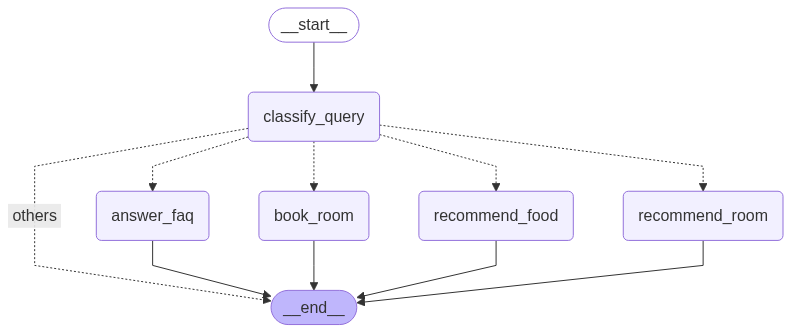

In [29]:
graph

In [30]:
config = {"configurable": {"thread_id": "1", "username": "user1"}}

In [31]:
output = graph.invoke({"messages": ["Hello, how are you?"]},config)

❓ Answering FAQ...


In [32]:
output['messages']

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='247d932e-c9ab-401f-9404-29844fbe9eb3')]

In [47]:
graph.invoke({"messages": ["how is the weather there?"]},config)

❓ Answering FAQ...


{'messages': [HumanMessage(content='Can you book a room for me?', additional_kwargs={}, response_metadata={}, id='6bdeba38-4ed5-4b93-9927-54c5d44626fe'),
  HumanMessage(content='how is the weather there?', additional_kwargs={}, response_metadata={}, id='91ae7e4e-7148-49b1-9e35-46ccc3782803')],
 'intent': 'answer_faq'}

In [34]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='247d932e-c9ab-401f-9404-29844fbe9eb3'), HumanMessage(content='is this refundable?', additional_kwargs={}, response_metadata={}, id='3c8f4900-0415-4daf-92a4-2b62943c1a46')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05db0e-a48c-6392-8006-ba8db69a30db'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}, 'thread_id': '1', 'username': 'user1'}, created_at='2025-07-10T17:11:27.474958+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05db0e-a489-6d9a-8005-4b872149122c'}}, tasks=(), interrupts=())

In [35]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='247d932e-c9ab-401f-9404-29844fbe9eb3'), HumanMessage(content='is this refundable?', additional_kwargs={}, response_metadata={}, id='3c8f4900-0415-4daf-92a4-2b62943c1a46')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05db0e-a48c-6392-8006-ba8db69a30db'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}, 'thread_id': '1', 'username': 'user1'}, created_at='2025-07-10T17:11:27.474958+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05db0e-a489-6d9a-8005-4b872149122c'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='247d932e-c9ab-401f-9404-29844fbe9eb3'), HumanMessage(content='is this refundable?', additional_kwargs={}, response_metadata={}, id='3c8f4900-

In [36]:
from langgraph.store.memory import InMemoryStore

In [37]:
in_memory_store = InMemoryStore()

In [38]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

In [39]:
memory_id = "id1"

In [40]:
memory = {'food_preference':'I like pizza'}

In [41]:
in_memory_store.put(namespace_for_memory, memory_id, memory)

In [42]:
in_memory_store.search(namespace_for_memory)[-1].dict()

{'namespace': ['1', 'memories'],
 'key': 'id1',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-07-10T17:11:27.582346+00:00',
 'updated_at': '2025-07-10T17:11:27.582351+00:00',
 'score': None}

In [43]:
in_memory_store.get(namespace_for_memory, memory_id)

Item(namespace=['1', 'memories'], key='id1', value={'food_preference': 'I like pizza'}, created_at='2025-07-10T17:11:27.582346+00:00', updated_at='2025-07-10T17:11:27.582351+00:00')

In [44]:
import sys
import os
sys.path.append(os.path.abspath("../"))  

In [45]:
config = {"configurable": {"thread_id": "1", "username": "user1"}}

In [46]:
from app.graph import build_chatbot_graph

if __name__ == "__main__":
    graph = build_chatbot_graph()

    state = {"messages": [{"role": "user", "content": "Can you book a room for me?"}]}
    output = graph.invoke(state, config)

    print("Final State:", output)


📦 Booking a room...
Final State: {'messages': [HumanMessage(content='Can you book a room for me?', additional_kwargs={}, response_metadata={}, id='6bdeba38-4ed5-4b93-9927-54c5d44626fe')], 'intent': 'book_room'}
